# Financial Data Structures for Machine Learning Applications

<b> YouTube Tutorial </b> (Published: Oct 6, 2021): https://youtu.be/c6_cW8-wBIk

Today we will be exploring the financial data structures as discussed in Advances in Financial Machine Learning by Prof. Marcos Lopez de Prado [2018].

Table 2.1 The Four Essential Types of Financial Data

Fundamental Data | Market Data | Analytics | Alternative Data
:-:|:-:|:-:|:-:
Assets|**Price**/yield/implied volatility| Analyst recommendations | Satellite/CCTV images
Liabilities|**Volume**| Credit ratings | Google searchers
Sales|Dividend/coupons| Earnings expectations | Twitter/chats
Cost/earnings|Open interest| News sentiment | Metadata
Macro variables|Quotes/cancellations| ... | ...

### Standard Bars for Financial Machine Learning
1. Time Bars
2. Tick Bars
3. Volume Bars
4. Dollar Bars

First let's import our dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

Import the course of sales or trade tick information. Here I only have access to one day's worth of trade history freely provided by my broker CommSec.

In [ ]:
trades = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/CBA_trades.csv')
trades.head()

,Time,Price $,Volume,Value $,Market,Condition
0,6/10/2021 17:00,100.0800,12904,1291432.320,ASX,ET XT
1,6/10/2021 16:54,100.0800,19280,1929542.400,ASX,ET XT
2,6/10/2021 16:47,100.3127,18517,1857490.266,CXA,SX XT
3,6/10/2021 16:46,100.0800,5364,536829.120,CXA,NaN
4,6/10/2021 16:45,100.0800,24624,2464369.920,ASX,ET XT


Now we need to transform the trade pandas dataframe into a format with datetime as the index.

In [ ]:
trades.Time = pd.to_datetime(trades.Time)
trades.set_index('Time', inplace=True)

Look at volume of trades vs time.

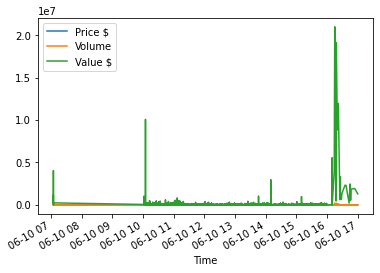

In [ ]:
trades.plot()

Apply mask of only market open hours

In [ ]:
mask = (trades.index > dt.datetime(2021,6,10,10,0,0)) & (trades.index <= dt.datetime(2021,6,10,16,0,0))

In [ ]:
trades_mh = trades.iloc[mask]
trades_mh.head()

,Price $,Volume,Value $,Market,Condition
Time,,,,,
2021-06-10 15:59:00,100.00,3,300.00,ASX,NaN
2021-06-10 15:59:00,100.00,21,2100.00,ASX,NaN
2021-06-10 15:59:00,99.96,2,199.92,ASX,XT
2021-06-10 15:59:00,99.96,1,99.96,ASX,XT
2021-06-10 15:59:00,100.00,7,700.00,ASX,NaN


## 1. Time Bars

Time bars are obtained by sampling information at fixed intervals e.g. once every 5 minutes.

In [ ]:
time_bars = trades_mh.groupby(pd.Grouper(freq='1min')).agg({'Price $': 'ohlc', 'Volume': 'sum'})
time_bars_price = time_bars.loc[:, 'Price $']
time_bars_price

,open,high,low,close
Time,,,,
2021-06-10 10:02:00,102.93,102.94,101.91,102.000
2021-06-10 10:03:00,102.66,103.07,102.65,102.960
2021-06-10 10:04:00,102.41,102.72,102.32,102.660
2021-06-10 10:05:00,102.50,102.52,102.41,102.410
2021-06-10 10:06:00,102.48,102.59,102.48,102.505
...,...,...,...,...
2021-06-10 15:55:00,99.84,99.95,99.78,99.950
2021-06-10 15:56:00,99.79,99.85,99.76,99.840
2021-06-10 15:57:00,99.89,99.90,99.76,99.760


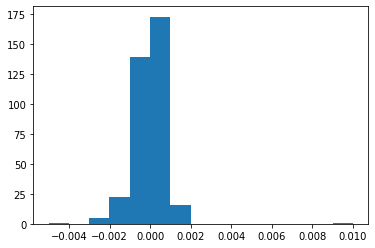

In [ ]:
time_bars = np.log(time_bars_price.close/time_bars_price.close.shift(1)).dropna()

bin_len = 0.001
plt.hist(time_bars, bins=np.arange(min(time_bars),max(time_bars)+bin_len, bin_len))
plt.show()

### What are the Issues?
- oversampling information from low-activity periods
- undersampling information from high-activity periods
- Time-sampled data often have poor statistical properties (Easley, Lopez de Prado, and O'Hara [2011]):
    - **serial correlation**: correlation of data with a delayed copy of itself (lag)
    - **heteroschedasticity**: variance (residual term variation/error) changes over time
    - **non-normality of returns**
    
This can cause issues in our Analysis:
 - Autocorrelation can cause problems in conventional analyses (such as ordinary least squares regression) that assume independence of observations.
 - Heteroscedasticity is a problem because ordinary least squares (OLS) regression assumes that all residuals are drawn from a population that has a constant variance (homoscedasticity).

GARCH models were developed to deal with heteroschedasticity. By sampling price and volume information as a subordinated process of trading activity we can avoid this problem to begin with.

Helper bar function to construct / return a integer number of bars.

In [ ]:
def bar(x, y):
    return np.int64(x/y)*y

## 2. Tick Bars

The sample variables Open, High, Low, Close and Volume are sampled over a pre-defined number of transactions.

In [ ]:
transactions = 75

tick_bars = trades_mh.groupby(bar(np.arange(len(trades_mh)), transactions)).agg({'Price $': 'ohlc', 'Volume': 'sum'})
tick_bars_price = tick_bars.loc[:, 'Price $']
tick_bars_price

,open,high,low,close
0,100.000,100.00,99.90,99.90
75,99.910,99.95,99.91,99.92
150,99.920,99.95,99.91,99.92
225,99.920,99.96,99.88,99.88
300,99.890,99.89,99.87,99.87
...,...,...,...,...
65850,101.995,102.05,101.91,102.00
65925,102.000,102.00,102.00,102.00
66000,102.000,102.00,102.00,102.00
66075,102.000,102.00,102.00,102.00


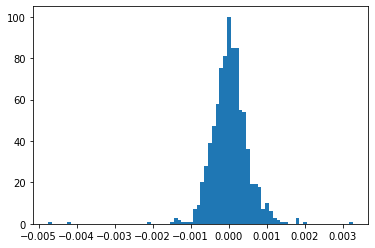

In [ ]:
tick_bars = np.log(tick_bars_price.close/tick_bars_price.close.shift(1)).dropna()

bin_len = 0.0001
plt.hist(tick_bars, bins=np.arange(min(tick_bars),max(tick_bars)+bin_len, bin_len))
plt.show()

## 3. Volume Bars

Volume bars are sampled every time a pre-defined amount the the security's units have been exchanged.

In [ ]:
traded_volume = 10000

volume_bars = trades_mh.groupby(bar(np.cumsum(trades_mh['Volume']), traded_volume)).agg({'Price $': 'ohlc', 'Volume': 'sum'})
volume_bars_price = volume_bars.loc[:,'Price $']
volume_bars_price

,open,high,low,close
0,100.00,100.00,99.90,99.92
10000,99.92,99.96,99.87,99.88
20000,99.88,99.90,99.86,99.86
30000,99.86,99.87,99.76,99.80
40000,99.80,99.83,99.76,99.83
...,...,...,...,...
4470000,102.00,102.00,102.00,102.00
4480000,102.00,102.00,102.00,102.00
4490000,102.00,102.00,102.00,102.00
4500000,102.00,102.00,102.00,102.00


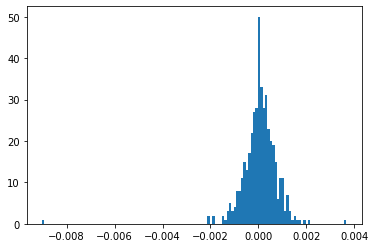

In [ ]:
volume_bars = np.log(volume_bars_price.close/volume_bars_price.close.shift(1)).dropna()

bin_len = 0.0001
plt.hist(volume_bars, bins=np.arange(min(volume_bars),max(volume_bars)+bin_len, bin_len))
plt.show()

## 4. Dollar Bars

Dollar bars are formed by sampling an observation every time a pre-defined market value is exchanged.

In [ ]:
market_value = 700000

dollar_bars = trades_mh.groupby(bar(np.cumsum(trades_mh['Value $']), market_value)).agg({'Price $': 'ohlc', 'Volume':'sum'})
dollar_bars_price = dollar_bars.loc[:,'Price $']
dollar_bars_price

,open,high,low,close
0,100.00,100.00,99.90,99.90
700000,99.90,99.96,99.90,99.95
1400000,99.94,99.94,99.87,99.88
2100000,99.88,99.90,99.87,99.89
2800000,99.89,99.90,99.80,99.82
...,...,...,...,...
449400000,102.00,102.00,102.00,102.00
450100000,102.00,102.00,102.00,102.00
450800000,102.00,102.00,102.00,102.00
451500000,102.00,102.00,102.00,102.00


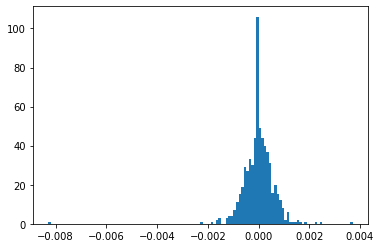

In [ ]:
dollar_bars = np.log(dollar_bars_price.close/dollar_bars_price.close.shift(1)).dropna()

bin_len = 0.0001
plt.hist(dollar_bars, bins=np.arange(min(dollar_bars),max(dollar_bars)+bin_len, bin_len))
plt.show()

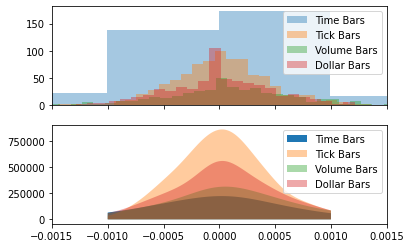

81

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

cdmx_edad = np.random.normal(0, 20,10000)+10
ed_sup_edad = dollar_bars

dollar_bars = np.log(dollar_bars_price.close/dollar_bars_price.close.shift(1)).dropna()
volume_bars = np.log(volume_bars_price.close/volume_bars_price.close.shift(1)).dropna()
tick_bars = np.log(tick_bars_price.close/tick_bars_price.close.shift(1)).dropna()
time_bars = np.log(time_bars_price.close/time_bars_price.close.shift(1)).dropna()


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
# bins = np.arange(10,61,1)
bin_len = 0.001
ax1.hist(time_bars, bins=np.arange(min(time_bars),max(time_bars)+bin_len, bin_len),alpha=0.4, label='Time Bars')
bin_len = 0.0001
ax1.hist(tick_bars, bins=np.arange(min(tick_bars),max(tick_bars)+bin_len, bin_len),alpha=0.4, label='Tick Bars')
ax1.hist(volume_bars, bins=np.arange(min(volume_bars),max(volume_bars)+bin_len, bin_len),alpha=0.4, label='Volume Bars')
ax1.hist(dollar_bars, bins=np.arange(min(dollar_bars),max(dollar_bars)+bin_len, bin_len),alpha=0.4, label='Dollar Bars')

ax1.legend()

dollar_bars_kde = stats.gaussian_kde(dollar_bars)
tick_bars_kde = stats.gaussian_kde(tick_bars)
volume_bars_kde = stats.gaussian_kde(volume_bars)
time_bars_kde = stats.gaussian_kde(time_bars)

x = np.linspace(-0.001,0.001,500)
dollar_bars_curve = dollar_bars_kde(x)*dollar_bars.shape[0]
tick_bars_curve = tick_bars_kde(x)*tick_bars.shape[0]
volume_bars_curve = volume_bars_kde(x)*volume_bars.shape[0]
time_bars_curve = time_bars_kde(x)*time_bars.shape[0]

# ax2.plot(x, cdmx_curve, color='r')
ax2.fill_between(x, 0, time_bars_curve, alpha=1, label='Time Bars')
ax2.fill_between(x, 0, tick_bars_curve, alpha=0.4, label='Tick Bars')
ax2.fill_between(x, 0, volume_bars_curve, alpha=0.4, label='Volume Bars')
ax2.fill_between(x, 0, dollar_bars_curve, alpha=0.4, label='Dollar Bars')

ax1.set_xlim(-0.0015,0.0015)

# ax2.plot(x, ed_sup_curve, color='b')
ax2.legend()
plt.show()

len_tick_bars =  np.arange(min(tick_bars),max(tick_bars)+bin_len, bin_len)
len(len_tick_bars)

Text(0.5, 1.0, 'KDE of Standard Price & Volume Bars')

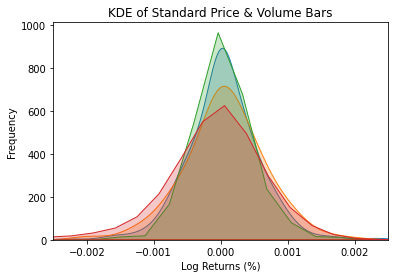

In [ ]:
sns.kdeplot(dollar_bars, gridsize=1000, shade=True, label='Dollar Bars')
sns.kdeplot(volume_bars, gridsize=1000, shade=True, label='Volume Bars')
sns.kdeplot(tick_bars, gridsize=25, shade=True, label='Tick Bars')
sns.kdeplot(time_bars, gridsize=50, shade=True, label='Time Bars')

plt.xlim(-0.0025,0.0025)

plt.xlabel('Log Returns (%)')
plt.ylabel('Frequency')
plt.title('KDE of Standard Price & Volume Bars')

# dollar_bars = np.log(dollar_bars_price.close/dollar_bars_price.close.shift(1)).dropna()
# volume_bars = np.log(volume_bars_price.close/volume_bars_price.close.shift(1)).dropna()
# tick_bars = np.log(tick_bars_price.close/tick_bars_price.close.shift(1)).dropna()
# time_bars = np.log(time_bars_price.close/time_bars_price.close.shift(1)).dropna()
# sns.kdeplot(eduacion_superior['EDAD'], shade=True)